In [1]:
import torch
import json
import numpy as np
import pandas as pd
from torch import nn

from utils import get_loaders
from classifier_utils import HateSpeechClassifier, forward_back_prop, \
                             train_classifier, batch_test, plot_confusion_matrices

tweets = np.load("data/tweets.npy")
labels = np.load("data/hate_original.npy")

with open('vocab_to_int.json', 'r') as fp:
    vocab_to_int = json.load(fp)

with open('int_to_vocab.json', 'r') as fp:
    int_to_vocab = json.load(fp)
    
train_on_gpu = torch.cuda.is_available()
print("Using GPU." if train_on_gpu else "Using CPU.")

Using GPU.


### Creating the Training, Validation, and Test Sets

In [2]:
train_loader, valid_loader, test_loader = get_loaders(tweets, labels)

			Feature Shapes:
Train set: 		(19826, 100) 
Validation set: 	(2478, 100) 
Test set: 		(2479, 100)


In [3]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 100])
Sample input: 
 tensor([[    0,     0,     0,  ...,   424, 15832, 10642],
        [    0,     0,     0,  ...,  9223, 10416, 21024],
        [    0,     0,     0,  ...,  9223,  9351,  8790],
        ...,
        [    0,     0,     0,  ...,  6036, 10764, 16616],
        [    0,     0,     0,  ..., 16880, 16880, 16880],
        [    0,     0,     0,  ..., 10642, 10642, 10642]], dtype=torch.int32)

Sample label size:  torch.Size([64])
Sample label: 
 tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2])


### Hyperparameters

In [4]:
sequence_length = tweets.shape[1]  # number of words in a sequence
num_epochs = 5
learning_rate = 0.0005
vocab_size = len(vocab_to_int)
output_size = pd.Series(labels).nunique()
embedding_dim = 25
hidden_dim = 256
batch_size = 64
n_layers = 2
show_every_n_batches = 50
cnn_params = (32, 25, 1, 4)
pool_params = (4, 4, 0)

### Model Instantiation

In [5]:
model = HateSpeechClassifier(vocab_size, output_size, embedding_dim, 
                             cnn_params, pool_params, hidden_dim, n_layers, 
                             dropout=0.5, embedding_path="glove/glove.twitter.27B.25d.txt", 
                             vocab_to_int=vocab_to_int, train_on_gpu=train_on_gpu)

if train_on_gpu:
    model.cuda()

Setting pretrained embedding weights...
4186 words in the vocabulary have no pre-trained embedding.


### Train network

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [7]:
model = train_classifier(model, batch_size, optimizer, criterion, num_epochs, train_loader, valid_loader,
                         show_every_n_batches=show_every_n_batches)

Training for 5 epoch(s)...
Epoch: 1/5. 	Batch: 50/310.	 Avg. Training Loss: 0.7172253233194351
Epoch: 1/5. 	Batch: 100/310.	 Avg. Training Loss: 0.6377925878763199
Epoch: 1/5. 	Batch: 150/310.	 Avg. Training Loss: 0.5824156413475673
Epoch: 1/5. 	Batch: 200/310.	 Avg. Training Loss: 0.5489801146090031
Epoch: 1/5. 	Batch: 250/310.	 Avg. Training Loss: 0.5149113618731499
Epoch: 1/5. 	Batch: 300/310.	 Avg. Training Loss: 0.4938226673007011
Epoch: 1 	Training Loss: 0.486976 	Validation Loss: 0.371260 	 Accuracy: 87.500000

Epoch: 2/5. 	Batch: 50/310.	 Avg. Training Loss: 0.3429980859160423
Epoch: 2/5. 	Batch: 100/310.	 Avg. Training Loss: 0.35352026104927065
Epoch: 2/5. 	Batch: 150/310.	 Avg. Training Loss: 0.3430738931894302
Epoch: 2/5. 	Batch: 200/310.	 Avg. Training Loss: 0.3416961857676506
Epoch: 2/5. 	Batch: 250/310.	 Avg. Training Loss: 0.33743099504709245
Epoch: 2/5. 	Batch: 300/310.	 Avg. Training Loss: 0.3346550764143467
Epoch: 2 	Training Loss: 0.334531 	Validation Loss: 0.327499 

### Test network

In [8]:
test_loss, test_acc, y_true, y_pred = batch_test(model, batch_size, test_loader, criterion, prnt=True)

Test loss: 0.317
Test accuracy: 87.7%


Confusion matrix, without normalization
Normalized confusion matrix


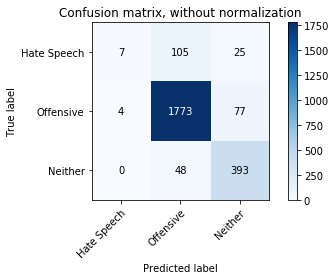

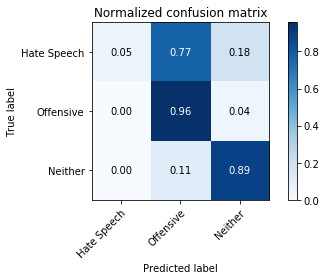

In [9]:
plot_confusion_matrices(y_true, y_pred)